In the NCLT dataset the LiDAR measurements are done with the Velodyne HDL-32E. For each day we have two kinds of data:
- velodyne_hits.bin: binary file with all raw velodyne scans of the session with
    - timestamp
    - x,y,z - coordinates
    - intensity
    laser id
- velodyne_snyc: contains one binary file for each timestamp with movement and time sync 360° scans

We need the files from velodyne_sync

In [1]:
import numpy as np
from pathlib import Path

from src.utils import calculate_m2dp_descriptor, run_evaluations, visualize_evaluations, visualize_trajectory, get_gt_trajectory
from src.data_loader import load_place_recognition_data
from src.similarity_measure import retrieve_candidates, retrieve_loop_pos

SCAN_FOLDER = "data/velodyne"
DESCRIPTORS_FOLDER = "m2dp_descriptors"
GT_POSE_FOLDER = "data/gt_pose"

### M2DP Descriptor to capture geometric structure of LiDAR scans

In [6]:
base = Path(SCAN_FOLDER)
max_depth = 3

for p in base.rglob("*"):
    if p.is_dir():
        depth = len(p.relative_to(base).parts)
        if depth == max_depth:
            calculate_m2dp_descriptor(folder=p, output_dir="m2dp_descriptors", save=True, parallelize=True)

Found 33612 scans in data/velodyne/2012-01-15_vel/2012-01-15/velodyne_sync.
Parallelizing process with multi-threading.


Processing files: 100%|██████████| 33612/33612 [35:03<00:00, 15.98it/s]  


Done. Signature vector matrix shape: (33612, 32)
Descriptors saved in m2dp_descriptors/m2dp_2012-01-15.npy
Timestamps saved in m2dp_descriptors/timestamps_2012-01-15.npy
Found 28127 scans in data/velodyne/2012-01-08_vel/2012-01-08/velodyne_sync.
Parallelizing process with multi-threading.


Processing files: 100%|██████████| 28127/28127 [28:24<00:00, 16.50it/s]  


Done. Signature vector matrix shape: (28127, 32)
Descriptors saved in m2dp_descriptors/m2dp_2012-01-08.npy
Timestamps saved in m2dp_descriptors/timestamps_2012-01-08.npy
Found 26145 scans in data/velodyne/2012-01-22_vel/2012-01-22/velodyne_sync.
Parallelizing process with multi-threading.


Processing files: 100%|██████████| 26145/26145 [26:42<00:00, 16.32it/s]  


Done. Signature vector matrix shape: (26145, 32)
Descriptors saved in m2dp_descriptors/m2dp_2012-01-22.npy
Timestamps saved in m2dp_descriptors/timestamps_2012-01-22.npy


### Histogram-Based Similarity Measure for Loop Closure Detection in 3D LiDAR Data

Descriptor: m2dp_descriptors/descriptors/m2dp_2012-01-15.npy | Shape: (33612, 32)
Descriptors timestamps: m2dp_descriptors/timestamps/timestamps_2012-01-15.npy
Ground Truth data: data/gt_pose/groundtruth_2012-01-15.csv



Computing loop candidates: 100%|██████████| 33612/33612 [00:13<00:00, 2452.10it/s] 


Candidates found: 121


Computing loop candidate positions & Extracting ground truth loop positions: 100%|██████████| 121/121 [00:00<00:00, 10508.56it/s]
Visualizing trajectory: 100%|██████████| 121/121 [00:00<00:00, 161.79it/s]


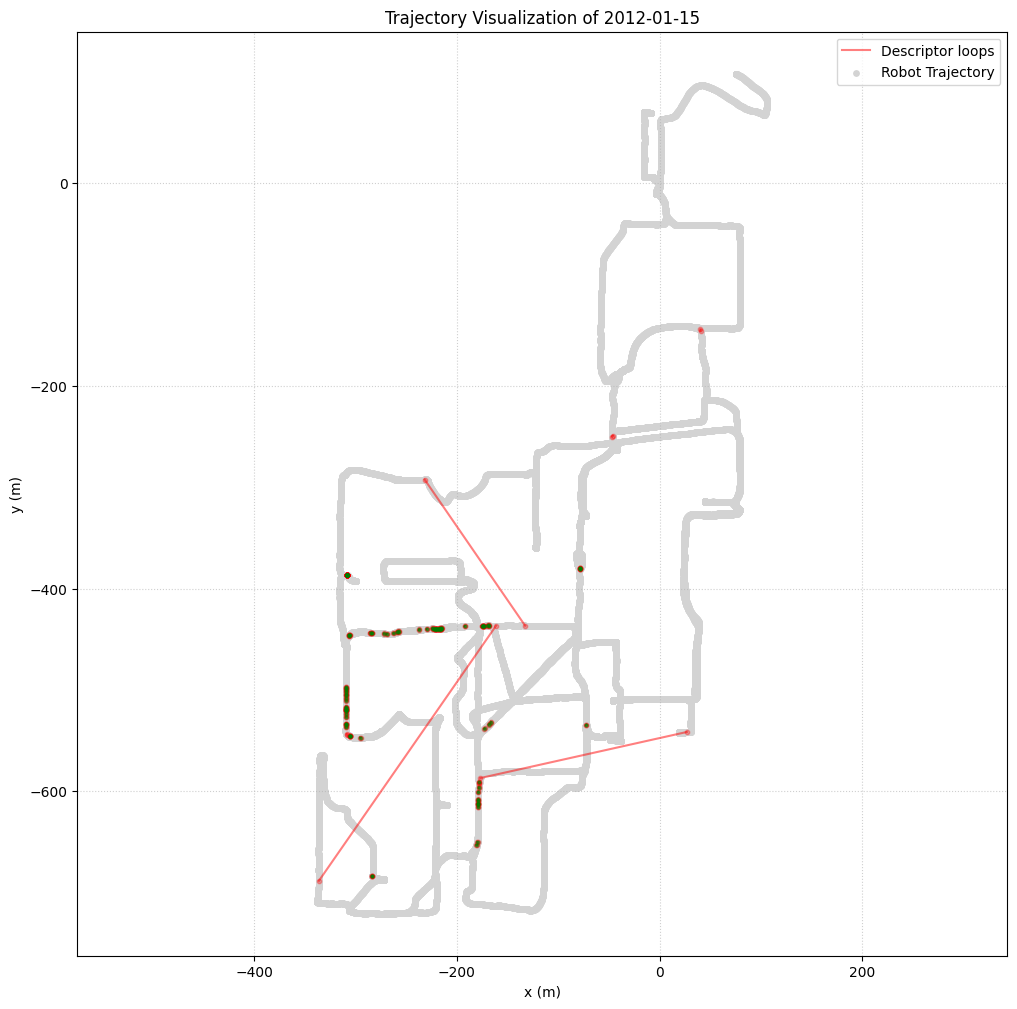

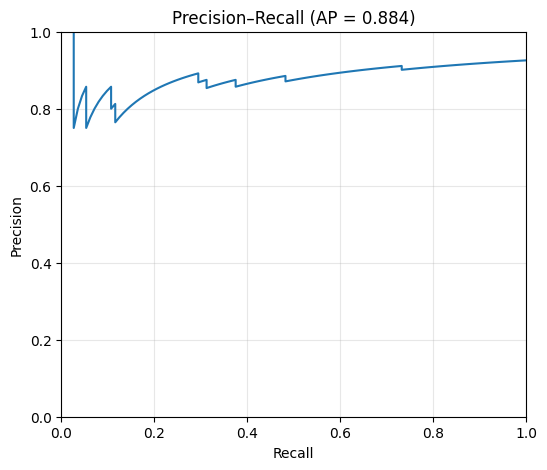

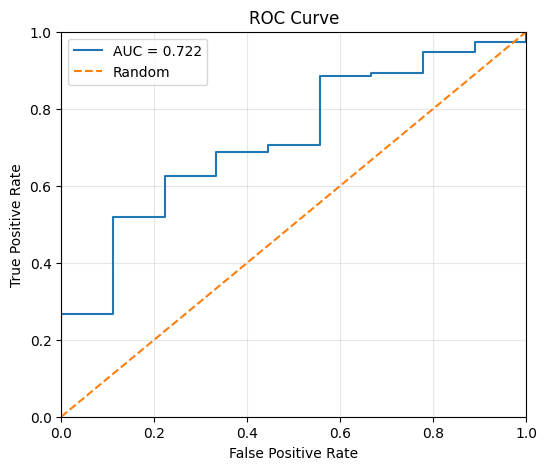

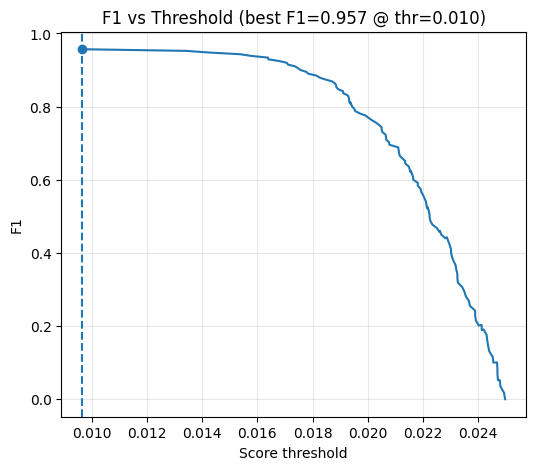


Descriptor: m2dp_descriptors/descriptors/m2dp_2012-01-22.npy | Shape: (26145, 32)
Descriptors timestamps: m2dp_descriptors/timestamps/timestamps_2012-01-22.npy


/home/undefined/Uni/semester-2/AMR/ex3/LiDAR-Descriptor/src/data_loader.py:38: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  gt = pd.read_csv(gt_csv_path,


Ground Truth data: data/gt_pose/groundtruth_2012-01-22.csv



Computing loop candidates: 100%|██████████| 26145/26145 [00:03<00:00, 8409.75it/s] 


Candidates found: 186


Computing loop candidate positions & Extracting ground truth loop positions: 100%|██████████| 186/186 [00:00<00:00, 8943.28it/s]
Visualizing trajectory: 100%|██████████| 186/186 [00:00<00:00, 186.80it/s]


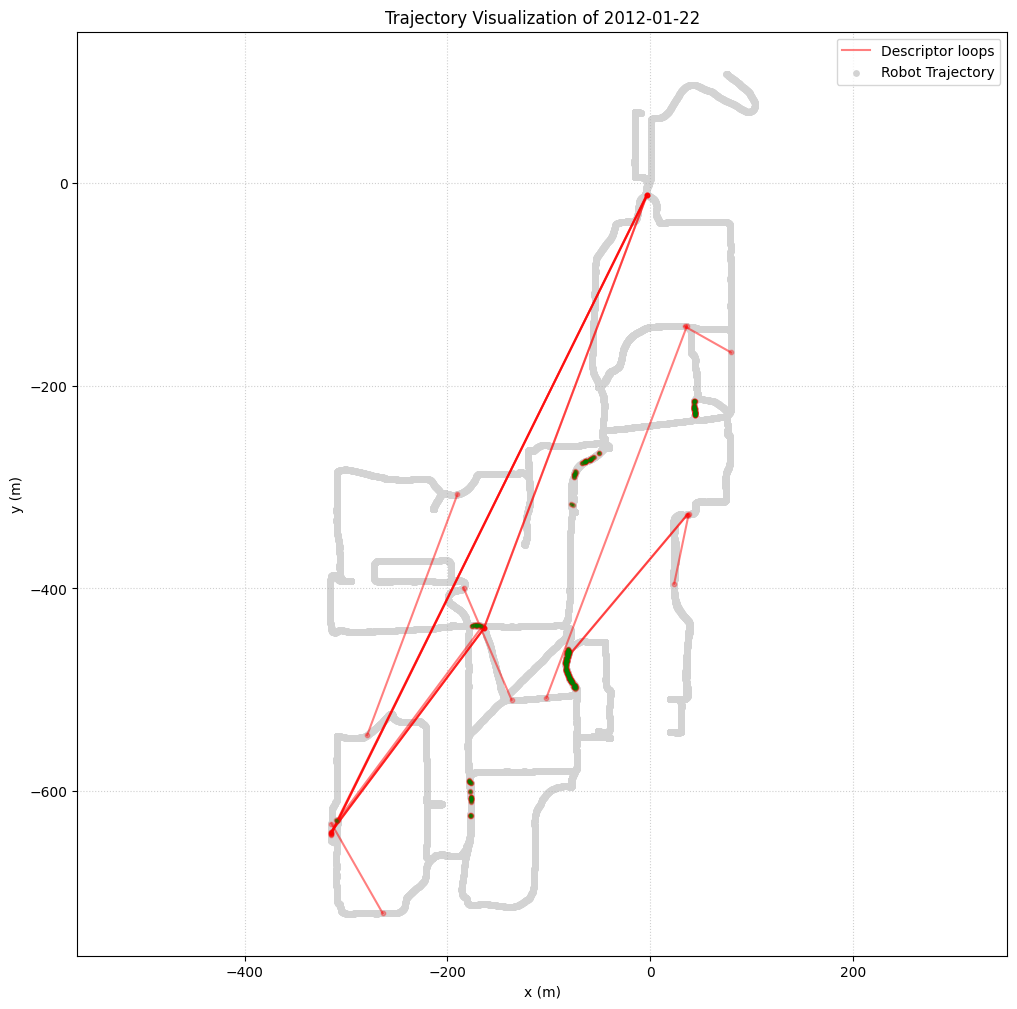

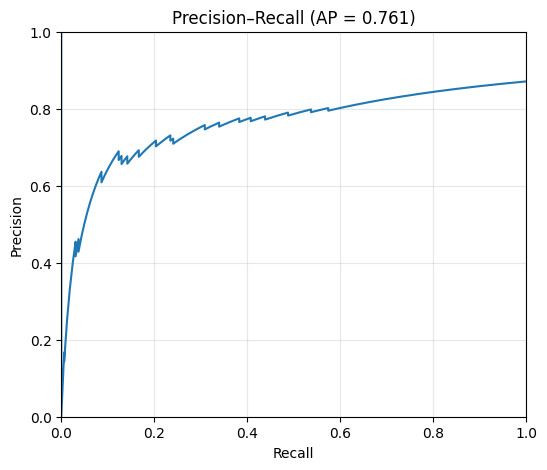

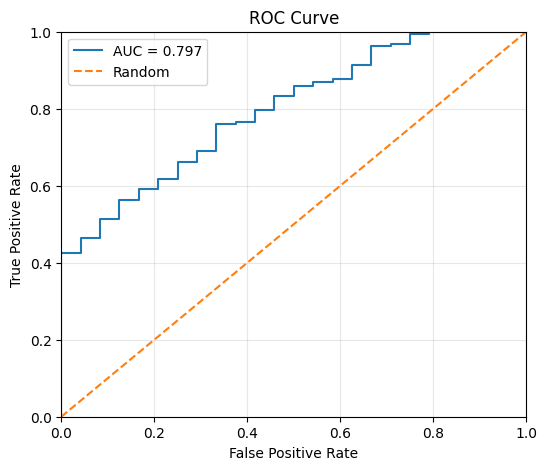

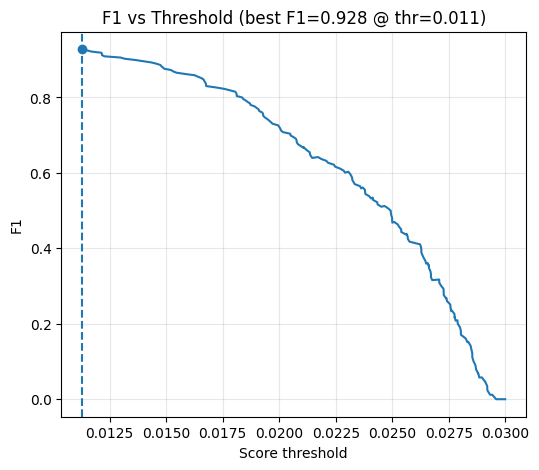


Descriptor: m2dp_descriptors/descriptors/m2dp_2012-01-08.npy | Shape: (28127, 32)
Descriptors timestamps: m2dp_descriptors/timestamps/timestamps_2012-01-08.npy


/home/undefined/Uni/semester-2/AMR/ex3/LiDAR-Descriptor/src/data_loader.py:38: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  gt = pd.read_csv(gt_csv_path,


Ground Truth data: data/gt_pose/groundtruth_2012-01-08.csv



Computing loop candidates: 100%|██████████| 28127/28127 [00:03<00:00, 8732.43it/s] 


Candidates found: 706


Computing loop candidate positions & Extracting ground truth loop positions: 100%|██████████| 706/706 [00:00<00:00, 9410.63it/s]
Visualizing trajectory: 100%|██████████| 705/705 [00:08<00:00, 82.43it/s] 


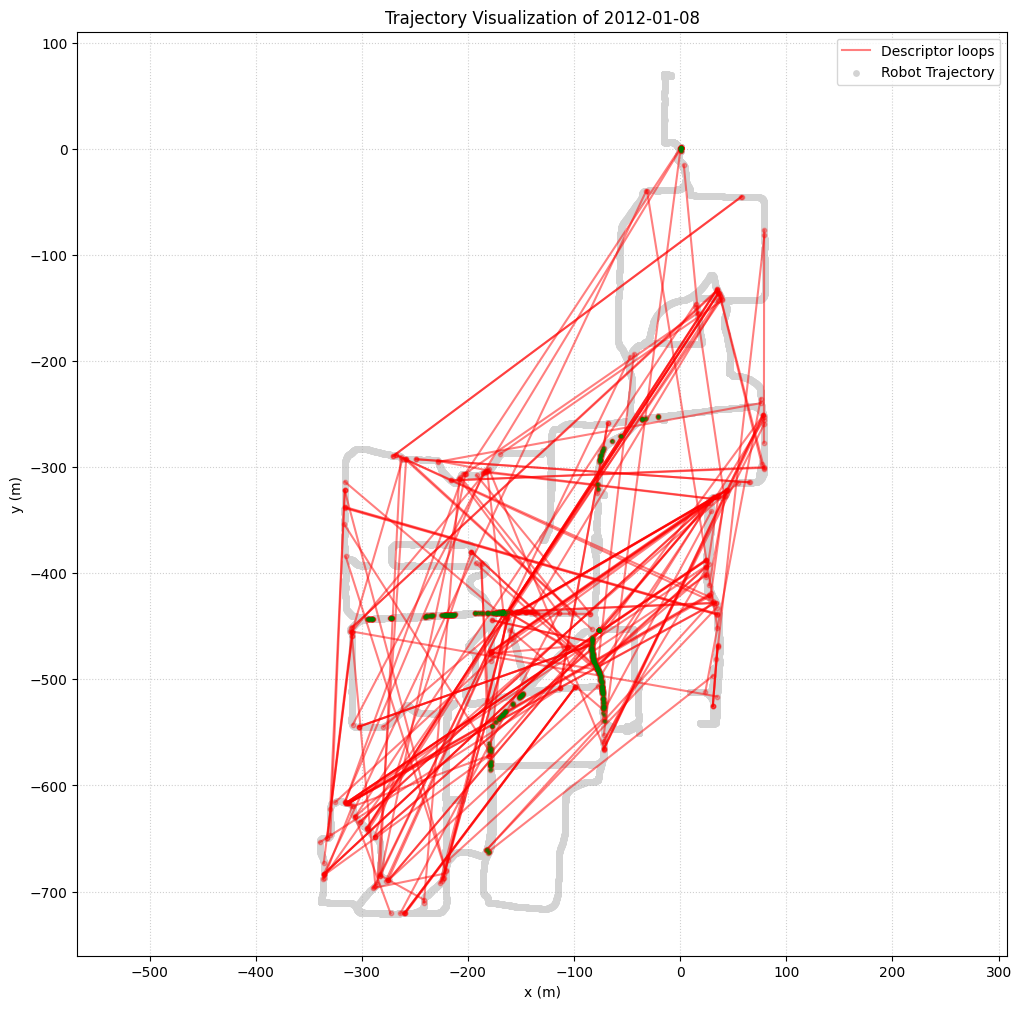

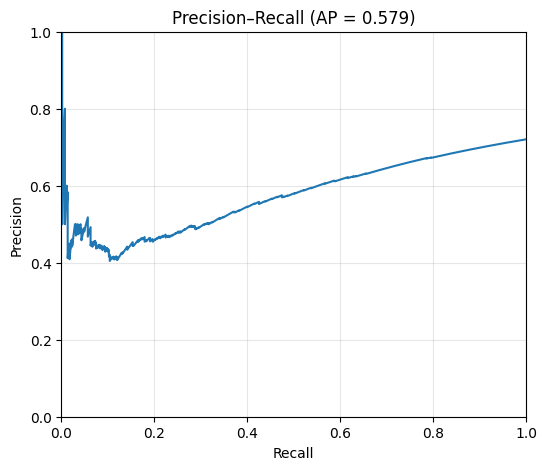

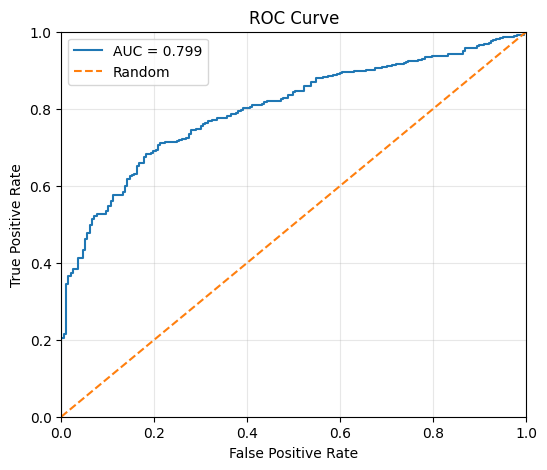

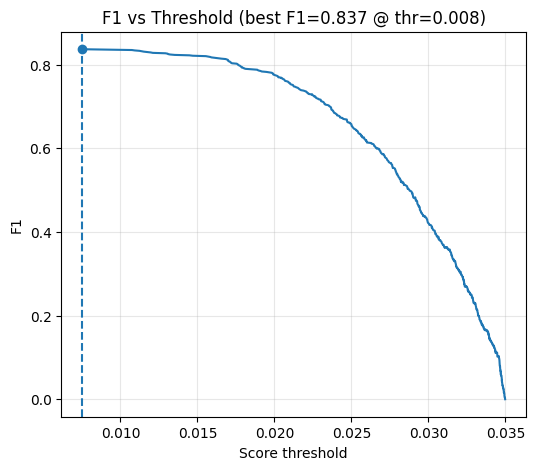

In [3]:
tau = [0.025, 0.03, 0.035]
window = 200
topk = 1

r = [1.0, 3.0, 5.0]
time_window = 30

for i, p in enumerate(Path(DESCRIPTORS_FOLDER+"/descriptors").iterdir()):
    day = p.name.split("_")[1].removesuffix(".npy")    
    descriptors, timestamps, gt = load_place_recognition_data(p, DESCRIPTORS_FOLDER, GT_POSE_FOLDER)
    
    # calculate loop candidates, its position based on gt timestamps and gt loops
    loop_candidates = retrieve_candidates(descriptors, window, tau[i], topk)
    candidates_loop_pos, y_true, y_score = retrieve_loop_pos(loop_candidates, timestamps, gt, time_window, r[i])

    # visualize trajectory with loop positions
    trajectory, _ = get_gt_trajectory(gt, timestamps)
    visualize_trajectory(trajectory, candidates_loop_pos, y_true, day)

    # evaluate
    recall, precision, ap_score, fpr, tpr, roc_auc, pr_thresholds = run_evaluations(y_true, y_score)
    visualize_evaluations(recall, precision, ap_score, fpr, tpr, roc_auc, pr_thresholds)
    
    print()

In [6]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree
from tqdm import tqdm

def compute_gt_loops_pos(timestamps, gt, time_window, r):
    """
    KDTree-basierte Loop-Kandidaten:
    - Interpoliert Positionen für alle timestamps
    - Sucht räumliche Nachbarn innerhalb Radius r
    - Filtert per Mindest-Frame-Abstand und Zeitfenster

    Rückgabe: Liste von (i, j, p_i, p_j)
    """
    min_frame_gap = int(time_window * 10)  # 10 Hz (wenn timestamps ~10Hz sind)

    # --- sort GT ---
    gt_sorted = gt.sort_values("timestamp")
    ts_gt = gt_sorted["timestamp"].to_numpy()
    pos_gt = gt_sorted[["x", "y"]].to_numpy()

    # --- interpolate all scan positions at once ---
    interp_pos = interp1d(
        ts_gt,
        pos_gt,
        axis=0,
        kind="linear",
        bounds_error=False,
        fill_value=np.nan,
        assume_sorted=True,
    )

    scan_pos = interp_pos(timestamps)

    # remove NaNs
    valid_mask = ~np.isnan(scan_pos).any(axis=1)
    valid_indices = np.where(valid_mask)[0]
    valid_pos = scan_pos[valid_mask]

    # --- build KDTree ---
    tree = cKDTree(valid_pos)

    # timestamps -> float time (wie in deinem Original)
    # Achtung: bei datetime64 ist astype(float) nicht immer stabil, daher int64-basierte Umwandlung:
    ts = np.asarray(timestamps)
    if np.issubdtype(ts.dtype, np.datetime64):
        t_float = ts.astype("datetime64[ns]").astype(np.int64).astype(np.float64) * 1e-6
    else:
        t_float = ts.astype(np.float64)

    gt_loops = []

    for idx, i in enumerate(tqdm(valid_indices, desc="Computing ground truth loops")):
        # spatial neighbors within radius r (in valid-index-space)
        neighbors = tree.query_ball_point(valid_pos[idx], r)

        for n in neighbors:
            j = int(valid_indices[n])

            # enforce ordering (j < i)
            if j >= i:
                continue

            # enforce a minimum gap in frames (optional heuristic)
            if (i - j) < min_frame_gap:
                continue

            # time diff check
            time_diff = abs(t_float[i] - t_float[j])
            if time_diff > time_window:
                gt_loops.append((int(i), int(j), scan_pos[int(i)], scan_pos[int(j)]))

    return gt_loops


gt_loops = compute_gt_loops_pos(timestamps, gt, time_window, r=0.3)
print(len(gt_loops))


Computing ground truth loops: 100%|██████████| 33463/33463 [00:00<00:00, 83725.45it/s]

8412
